# BigContest Prediction

# 1. Load library

In [3]:
library(data.table) # Data load
library(dplyr) # Preprocessing
library(tidyr) # Preprocessing
library(caret) # Modeling
library(party) # Decision Tree
library(randomForest) # Random Forest

In [4]:
theme_set(theme_bw())
options(repr.plot.width=10, repr.plot.height=7, warn = -1)

# 2. Load data

In [5]:
activity <- fread("data/futureleague/reform/train_activity_new.csv", stringsAsFactors = F)
guild    <- fread("data/futureleague/reform/train_guild_new.csv", stringsAsFactors = F)
label    <- fread("data/futureleague/reform/train_label.csv", stringsAsFactors = F)
payment  <- fread("data/futureleague/reform/train_payment_new.csv", stringsAsFactors = F)

Read 440323 rows and 39 (of 39) columns from 0.305 GB file in 00:00:19
Read 800000 rows and 4 (of 4) columns from 0.071 GB file in 00:00:03


# 3. Predefined functions

In [6]:
# Predict churn using Logistic Regressin / Decision Tree / Randomforest without parameter tuning
predict_churn <- function(df, name, binary = T) {
  if (binary == T) {
    df <- df %>% mutate(label = ifelse(label == "retained", "0", "1") %>% factor())
    target <- "2-Class"
  } else {
    df <- df %>% mutate(label = factor(label))
    target <- "4-Class"
  }
  
  # Split
  train_id <- createDataPartition(df$label, p = 0.7, list = F)
  train    <- df[train_id,]
  test     <- df[-train_id,]
  
  # Modeling
  formula <- formula(label ~ .)
  
  dt.fit  <- ctree(formula, data = train)
  rf.fit  <- randomForest(formula, data = train)
  
  # predict
  dt.pred <- predict(dt.fit, test)
  rf.pred <- predict(rf.fit, test)
  
  # Result
  dt.result  <- confusionMatrix(dt.pred, test$label, positive = "1", mode = "everything")
  rf.result  <- confusionMatrix(rf.pred, test$label, positive = "1", mode = "everything")
  
  if (binary == T) {
    glm.fit <- glm(formula, data = train, family = "binomial")
    
    glm.prob <- predict(glm.fit, test, type = "response")
    glm.pred <- factor(ifelse(glm.prob > 0.5, 1, 0))
    
    glm.result <- confusionMatrix(glm.pred, test$label, positive = "1", mode = "everything")
    
    return(list(data = name,
                target = target,
                glm.model = glm.fit,
                dt.model = dt.fit,
                rf.model = rf.fit,
                logistic = glm.result, 
                decision.tree = dt.result, 
                randomforest = rf.result))
  } else {
    return(list(data = name,
                target = target,
                dt.model = dt.fit,
                rf.model = rf.fit,
                decision.tree = dt.result, 
                randomforest = rf.result))
  }
}

In [7]:
# Create result data frame
summarize_result <- function(result) {
  if (length(result) == 8) {
    result <- data.frame(data = rep(result$data, 3),
                         target = rep(result$target, 3),
                         method = c("logistic", "decision tree", "random forest"),
                         accuracy = c(result$logistic$overall["Accuracy"],
                                      result$decision.tree$overall["Accuracy"],
                                      result$randomforest$overall["Accuracy"]),
                         F1 = c(result$logistic$byClass["F1"],
                                result$decision.tree$byClass["F1"],
                                result$randomforest$byClass["F1"]), 
                        stringsAsFactors = F)
  } else if (length(result) == 6) {
    result <- data.frame(data = rep(result$data, 3),
                         target = rep(result$target, 3),
                         method = c("logistic", "decision tree", "random forest"),
                         accuracy = c(NA,
                                      result$decision.tree$overall["Accuracy"],
                                      result$randomforest$overall["Accuracy"]),
                         F1 = c(NA,
                                result$decision.tree$byClass[, "F1"] %>% mean(na.rm = T),
                                result$decision.tree$byClass[, "F1"] %>% mean(na.rm = T)), 
                        stringsAsFactors = F)
  } else {
    print("0")
  }
    return(result)
}

# 4. Transform data

## 4.1 Create payment variables

In [8]:
pay <- payment %>% group_by(acc_id) %>%
  summarize(payment_mean = mean(payment_amount))
head(pay)

acc_id,payment_mean
0000264b01392acfde44f9d8494f112a701dc5d3e5fda6ad090cb205727637e0,-0.1498985
0001f130e89288ff0df167b998f6eb7085687f411fcb72440d8a55fb2c0eabc8,-0.1498985
00028f0ad71c07f48aef465fd0c98ba6e3f0f3de3d2f7d14c975f794dfb31e2b,-0.1498985
00036e5b6a197c196fa10fc0ad4e2853b22294dff64d2735a2795ab3858d5b7a,-0.1498985
00037fe8e712041a476b8b1b827583cbc34895844057f03da985c953f567e0f2,-0.1498985
0003b127aa1c0c34490db8817574482464aad9f99cffde4d3e51790dff2cb6ca,-0.1498985


## 4.2 Create guild varibles

In [9]:
guild_join <- guild %>% group_by(acc_id) %>% summarize(join_num = n())
head(guild_join)

acc_id,join_num
000201ba3f72429177413620a3d22dfb348f21622fa7b67e2be2fbf4b06b21f6,1
0007838a3f353aa4a4c938d42ee43a2fa51b03557e624abc6d3ef2375588bd7c,1
00099da993f9a00f3c6575d844d4bf79a658d1e5845a8a17670641e5d15b1be2,1
000af534394783c3a1d28414ce6adc95af45657e34bf7045d41a7ec5cf1ad32f,1
000c7d37960d5261d7680320227e07e53580f654cf0322045a34d50b643a7a1b,1
000f75da470b53684a56be7c49083451cfa58db4573900af1ebe8ad1b1b2be37,1


## 4.3 Create time variables

In [10]:
time <- activity %>% group_by(acc_id) %>%
  summarize(wk_num = n(),
            access_mean = mean(cnt_dt),
            time_mean = mean(play_time))
head(time)

acc_id,wk_num,access_mean,time_mean
0000264b01392acfde44f9d8494f112a701dc5d3e5fda6ad090cb205727637e0,2,6.000000,3.6274881
0001f130e89288ff0df167b998f6eb7085687f411fcb72440d8a55fb2c0eabc8,8,3.125000,-0.6606956
00028f0ad71c07f48aef465fd0c98ba6e3f0f3de3d2f7d14c975f794dfb31e2b,5,2.400000,-0.6570603
00036e5b6a197c196fa10fc0ad4e2853b22294dff64d2735a2795ab3858d5b7a,6,5.166667,-0.5031993
00037fe8e712041a476b8b1b827583cbc34895844057f03da985c953f567e0f2,2,1.500000,-0.6552137
0003b127aa1c0c34490db8817574482464aad9f99cffde4d3e51790dff2cb6ca,8,4.875000,-0.4864409


In [11]:
week <- activity %>% select(acc_id, wk) %>% 
  mutate(value = 1) %>% spread(key = "wk", value = "value") %>%
  select(-c(8, 9))
week[is.na(week)] <- 0
names(week)[2:7] <- paste0("wk", 1:6)
head(week)

acc_id,wk1,wk2,wk3,wk4,wk5,wk6
0000264b01392acfde44f9d8494f112a701dc5d3e5fda6ad090cb205727637e0,0,0,0,0,0,0
0001f130e89288ff0df167b998f6eb7085687f411fcb72440d8a55fb2c0eabc8,1,1,1,1,1,1
00028f0ad71c07f48aef465fd0c98ba6e3f0f3de3d2f7d14c975f794dfb31e2b,0,0,1,1,1,0
00036e5b6a197c196fa10fc0ad4e2853b22294dff64d2735a2795ab3858d5b7a,1,0,1,1,0,1
00037fe8e712041a476b8b1b827583cbc34895844057f03da985c953f567e0f2,0,1,0,0,0,0
0003b127aa1c0c34490db8817574482464aad9f99cffde4d3e51790dff2cb6ca,1,1,1,1,1,1


## 4.4 Create battle variables

In [12]:
battle <- activity %>% group_by(acc_id) %>% 
  summarize(sum_duel_cnt = sum(duel_cnt),
            sum_partybattle_cnt = sum(partybattle_cnt)) %>%
  mutate(is_duel = ifelse(sum_duel_cnt > quantile(sum_duel_cnt, 0.3), 1, 0) %>% factor(),
         is_partybattle = ifelse(sum_partybattle_cnt > quantile(sum_partybattle_cnt, 0.3), 1, 0) %>% factor())
head(battle)

acc_id,sum_duel_cnt,sum_partybattle_cnt,is_duel,is_partybattle
0000264b01392acfde44f9d8494f112a701dc5d3e5fda6ad090cb205727637e0,-0.07233609,-0.3349451,1,1
0001f130e89288ff0df167b998f6eb7085687f411fcb72440d8a55fb2c0eabc8,-0.28934434,-1.3397803,0,0
00028f0ad71c07f48aef465fd0c98ba6e3f0f3de3d2f7d14c975f794dfb31e2b,-0.18084022,-0.8373627,1,1
00036e5b6a197c196fa10fc0ad4e2853b22294dff64d2735a2795ab3858d5b7a,-0.21700826,-1.0048352,0,0
00037fe8e712041a476b8b1b827583cbc34895844057f03da985c953f567e0f2,-0.07233609,-0.3349451,1,1
0003b127aa1c0c34490db8817574482464aad9f99cffde4d3e51790dff2cb6ca,-0.28934434,-1.3397803,0,0


## 4.5 Create exp variables

In [13]:
exp <- activity %>% group_by(acc_id) %>%
  summarize(mean_npc_exp = mean(npc_exp),
            sum_npc_exp = sum(npc_exp),
            mean_npc_hongmun = mean(npc_hongmun),
            sum_npc_hongmun = sum(npc_hongmun),
            mean_quest_exp = mean(quest_exp),
            sum_quest_exp = sum(quest_exp),
            mean_quest_hongmun = mean(quest_hongmun),
            sum_quest_hongmun = sum(quest_hongmun),
            mean_item_hongmun = mean(item_hongmun),
            sum_item_hongmun = sum(item_hongmun))
head(exp)

acc_id,mean_npc_exp,sum_npc_exp,mean_npc_hongmun,sum_npc_hongmun,mean_quest_exp,sum_quest_exp,mean_quest_hongmun,sum_quest_hongmun,mean_item_hongmun,sum_item_hongmun
0000264b01392acfde44f9d8494f112a701dc5d3e5fda6ad090cb205727637e0,6.0419654,12.0839307,-0.2382876,-0.4765752,6.82582813,13.6516563,4.9269363,9.8538726,-0.3063536,-0.6127072
0001f130e89288ff0df167b998f6eb7085687f411fcb72440d8a55fb2c0eabc8,-0.2318740,-1.8549924,-0.2908032,-2.3264256,-0.25042336,-2.0033868,-0.4876662,-3.9013300,-0.3063536,-2.4508288
00028f0ad71c07f48aef465fd0c98ba6e3f0f3de3d2f7d14c975f794dfb31e2b,-0.2317033,-1.1585167,-0.2908032,-1.4540160,-0.24953424,-1.2476712,-0.4876662,-2.4383312,-0.3063536,-1.5317680
00036e5b6a197c196fa10fc0ad4e2853b22294dff64d2735a2795ab3858d5b7a,-0.1822994,-1.0937964,-0.2858753,-1.7152516,-0.02764767,-0.1658860,-0.1518956,-0.9113734,-0.3035836,-1.8215017
00037fe8e712041a476b8b1b827583cbc34895844057f03da985c953f567e0f2,-0.2314473,-0.4628946,-0.2908032,-0.5816064,-0.24820057,-0.4964011,-0.4876662,-0.9753325,-0.3063536,-0.6127072
0003b127aa1c0c34490db8817574482464aad9f99cffde4d3e51790dff2cb6ca,-0.2318740,-1.8549924,-0.2579845,-2.0638759,-0.25042336,-2.0033868,-0.4546304,-3.6370430,-0.2850594,-2.2804749


# 5. Merge data

## 5.1 Payment / Guild

In [14]:
base.df <- label  %>% 
  left_join(pay, by = "acc_id") %>%
  left_join(guild_join, by = "acc_id") %>% 
  mutate(join_num = ifelse(is.na(join_num), 0, join_num),
         is_join = ifelse(join_num > 0, "1", "0") %>% factor()) %>%
  select(-acc_id)
head(base.df)

label,payment_mean,join_num,is_join
week,-0.1498985,0,0
week,-0.1498985,0,0
week,-0.1498985,0,0
week,5.3432672,0,0
week,-0.1498985,0,0
week,-0.1498985,0,0


## 5.2 Payment / Guild / Time

In [15]:
first.df <- label  %>% 
  left_join(pay, by = "acc_id") %>%
  left_join(guild_join, by = "acc_id") %>% 
  mutate(join_num = ifelse(is.na(join_num), 0, join_num),
         is_join = ifelse(join_num > 0, "1", "0") %>% factor()) %>%
  left_join(week, by = "acc_id") %>%
  left_join(time, by = "acc_id") %>%
  mutate(wk1 = factor(wk1),
         wk2 = factor(wk2),
         wk3 = factor(wk3),
         wk4 = factor(wk4),
         wk5 = factor(wk5),
         wk6 = factor(wk6)) %>%
  select(-acc_id)
head(first.df)

label,payment_mean,join_num,is_join,wk1,wk2,wk3,wk4,wk5,wk6,wk_num,access_mean,time_mean
week,-0.1498985,0,0,0,0,0,0,0,0,1,3.000000,1.5198148
week,-0.1498985,0,0,0,0,0,0,1,1,4,5.750000,1.7675336
week,-0.1498985,0,0,0,0,0,0,0,0,1,3.000000,1.1100352
week,5.3432672,0,0,0,0,0,0,0,0,1,1.000000,-0.6592145
week,-0.1498985,0,0,0,0,0,0,0,1,3,2.333333,-0.1372716
week,-0.1498985,0,0,0,0,0,0,0,0,1,4.000000,1.7031579


## 5.3 Payment / Guild / Time / Battle

In [16]:
second.df <- label  %>% 
  left_join(pay, by = "acc_id") %>%
  left_join(guild_join, by = "acc_id") %>% 
  mutate(join_num = ifelse(is.na(join_num), 0, join_num),
         is_join = ifelse(join_num > 0, "1", "0") %>% factor()) %>%
  left_join(week, by = "acc_id") %>%
  left_join(time, by = "acc_id") %>%
  left_join(battle, by = "acc_id") %>%
  mutate(wk1 = factor(wk1),
         wk2 = factor(wk2),
         wk3 = factor(wk3),
         wk4 = factor(wk4),
         wk5 = factor(wk5),
         wk6 = factor(wk6)) %>%
  select(-acc_id)
head(second.df)

label,payment_mean,join_num,is_join,wk1,wk2,wk3,wk4,wk5,wk6,wk_num,access_mean,time_mean,sum_duel_cnt,sum_partybattle_cnt,is_duel,is_partybattle
week,-0.1498985,0,0,0,0,0,0,0,0,1,3.000000,1.5198148,-0.03616804,-0.1674725,1,1
week,-0.1498985,0,0,0,0,0,0,1,1,4,5.750000,1.7675336,-0.14467217,-0.6698902,1,1
week,-0.1498985,0,0,0,0,0,0,0,0,1,3.000000,1.1100352,-0.03616804,-0.1674725,1,1
week,5.3432672,0,0,0,0,0,0,0,0,1,1.000000,-0.6592145,-0.03616804,-0.1674725,1,1
week,-0.1498985,0,0,0,0,0,0,0,1,3,2.333333,-0.1372716,-0.10850413,-0.5024176,1,1
week,-0.1498985,0,0,0,0,0,0,0,0,1,4.000000,1.7031579,-0.03616804,-0.1674725,1,1


## 5.4 Payment / Guild / Time / Battle / Exp

In [17]:
third.df <- label  %>% 
  left_join(pay, by = "acc_id") %>%
  left_join(guild_join, by = "acc_id") %>% 
  mutate(join_num = ifelse(is.na(join_num), 0, join_num),
         is_join = ifelse(join_num > 0, "1", "0") %>% factor()) %>%
  left_join(week, by = "acc_id") %>%
  left_join(time, by = "acc_id") %>%
  left_join(battle, by = "acc_id") %>%
  left_join(exp, by = "acc_id") %>%
  mutate(wk1 = factor(wk1),
         wk2 = factor(wk2),
         wk3 = factor(wk3),
         wk4 = factor(wk4),
         wk5 = factor(wk5),
         wk6 = factor(wk6)) %>%
  select(-acc_id)
head(third.df)

label,payment_mean,join_num,is_join,wk1,wk2,wk3,wk4,wk5,wk6,...,mean_npc_exp,sum_npc_exp,mean_npc_hongmun,sum_npc_hongmun,mean_quest_exp,sum_quest_exp,mean_quest_hongmun,sum_quest_hongmun,mean_item_hongmun,sum_item_hongmun
week,-0.1498985,0,0,0,0,0,0,0,0,...,2.9106849,2.910685,-0.2681098,-0.2681098,2.8522409,2.8522409,2.3329102,2.3329102,-0.3063536,-0.3063536
week,-0.1498985,0,0,0,0,0,0,1,1,...,2.7291466,10.916586,-0.1546110,-0.6184440,2.5097645,10.0390580,1.8400401,7.3601603,-0.2066343,-0.8265370
week,-0.1498985,0,0,0,0,0,0,0,0,...,2.9162327,2.916233,-0.2782909,-0.2782909,2.4315540,2.4315540,1.2610653,1.2610653,-0.3063536,-0.3063536
week,5.3432672,0,0,0,0,0,0,0,0,...,-0.2318740,-0.231874,-0.2908032,-0.2908032,-0.2504234,-0.2504234,-0.4876662,-0.4876662,-0.3063536,-0.3063536
week,-0.1498985,0,0,0,0,0,0,0,1,...,0.3649319,1.094796,-0.1800857,-0.5402570,0.4893202,1.4679606,0.2912995,0.8738986,-0.2523390,-0.7570169
week,-0.1498985,0,0,0,0,0,0,0,0,...,1.5446439,1.544644,0.4975927,0.4975927,1.9688073,1.9688073,1.8590120,1.8590120,-0.1110699,-0.1110699


# 6. Prediction

## 6.1 Predict - payment / guild

In [20]:
base_reduced  <- predict_churn(base.df, "payment / guild", binary = T) # Binary
base  <- predict_churn(base.df,"payment / guild", binary = F) # Multi

## 6.2 Predict - payment / guild / time

In [21]:
first_reduced <- predict_churn(first.df, "payment / guild / time", binary = T) # Binary
first <- predict_churn(first.df, "payment / guild / time", binary = F) # Multi

## 6.3 Predict  - payment / guild / time / battle

In [22]:
second_reduced <- predict_churn(second.df, "payment / guild / time / battle", binary = T) # Binary
second <- predict_churn(second.df, "payment / guild / time / battle", binary = F) # Multi

## 6.4 Predict - payment / guild / time / battle / exp

In [23]:
third_reduced <- predict_churn(third.df, "payment / guild / time / battle / exp", binary = T) # Binary
third <- predict_churn(third.df, "payment / guild / time / battle / exp", binary = F) # Multi

# 7. Summarize

## 7.1 Comare Accuracy

In [24]:
result <- summarize_result(base_reduced) %>%
  bind_rows(summarize_result(base)) %>%
  bind_rows(summarize_result(first_reduced)) %>%
  bind_rows(summarize_result(first)) %>%
  bind_rows(summarize_result(second_reduced)) %>%
  bind_rows(summarize_result(second)) %>%
  bind_rows(summarize_result(third_reduced)) %>%
  bind_rows(summarize_result(third)) %>%
  mutate(method = factor(method, levels = c("logistic", "decision tree", "random forest")))

In [25]:
result %>% group_by(target) %>% top_n(1, F1)

data,target,method,accuracy,F1
payment / guild / time / battle / exp,2-Class,random forest,0.8872333,0.9259624
payment / guild / time / battle / exp,4-Class,decision tree,0.6725333,0.6609431
payment / guild / time / battle / exp,4-Class,random forest,0.7058000,0.6609431


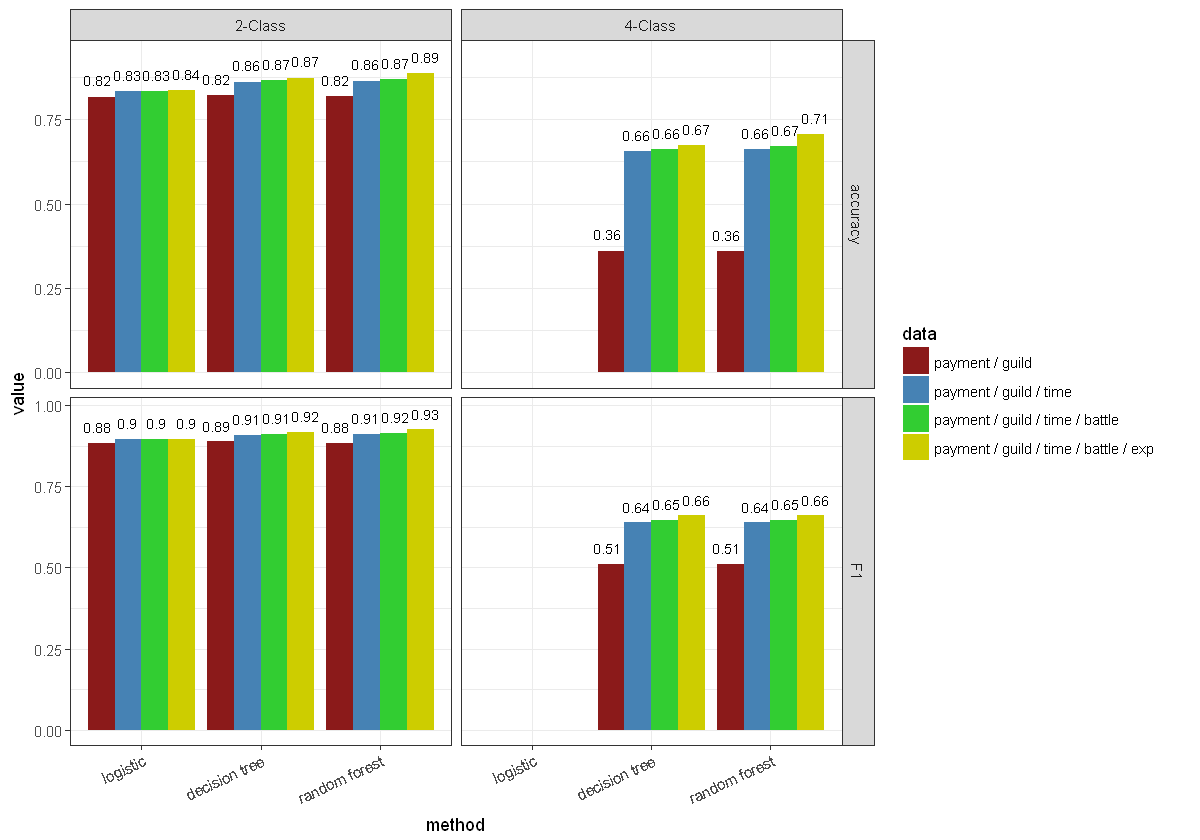

In [26]:
result %>% gather(key = "measure", value = "value", accuracy, F1) %>%
  ggplot(aes(method, value, fill = data)) + geom_bar(stat = "identity", position = "dodge") + 
  facet_grid(measure ~ target, scales = "free") +
  geom_text(aes(label = round(value, 2), y = value + 0.05), size = 3, position = position_dodge(width = 1)) + 
  scale_fill_manual(name = "data", values = c("firebrick4", "steelblue", "limegreen", "yellow3")) +
  theme(axis.text.x = element_text(angle = 25, hjust = 1))

## 7.2 Variable Importance

,Overall
payment_mean,1212.9198
join_num,1567.5135
is_join,1276.9421
wk1,1530.6010
wk2,240.0963
wk3,617.0624
wk4,270.2094
wk5,455.7313
wk6,288.7577
wk_num,2392.1201


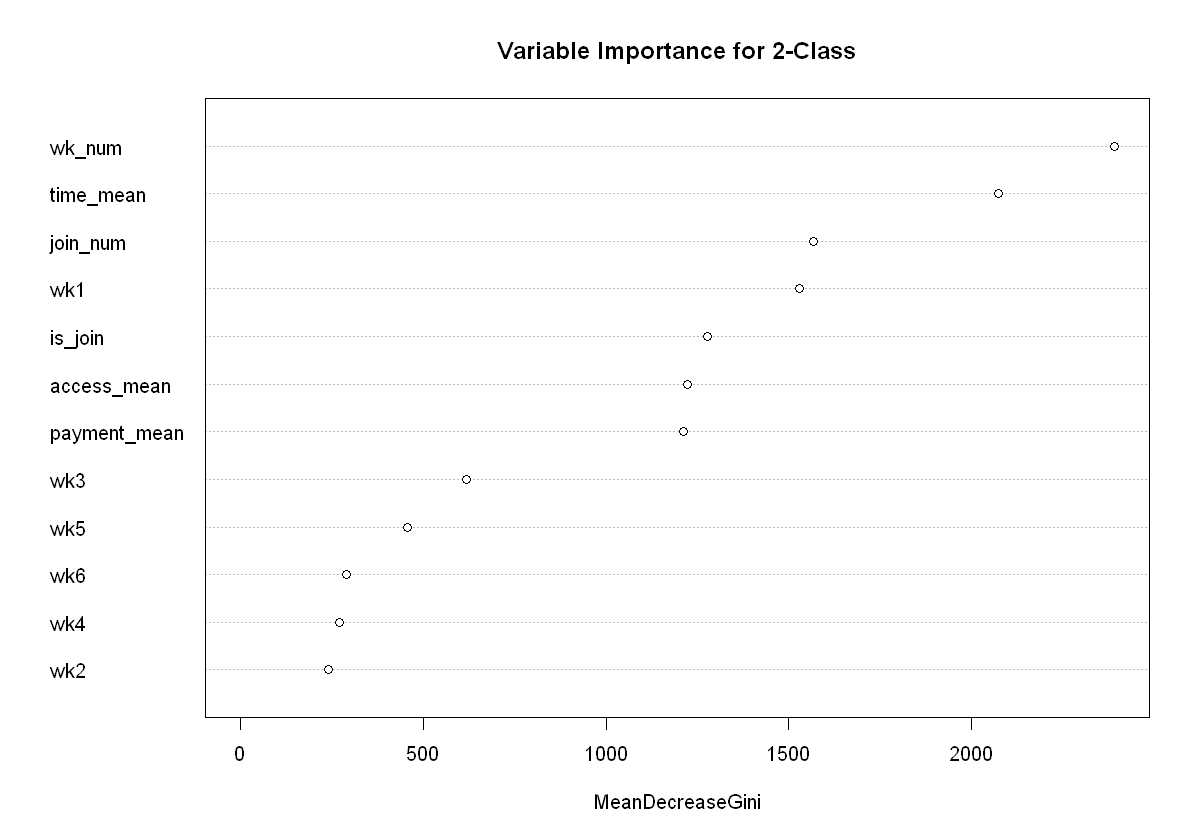

In [27]:
varImp(first_reduced$rf.model)
varImpPlot(first_reduced$rf.model, main = "Variable Importance for 2-Class")

,Overall
payment_mean,1365.0524
join_num,1608.4205
is_join,1149.3698
wk1,1482.3738
wk2,263.3397
wk3,499.5838
wk4,191.4291
wk5,405.1079
wk6,303.4994
wk_num,2245.6661


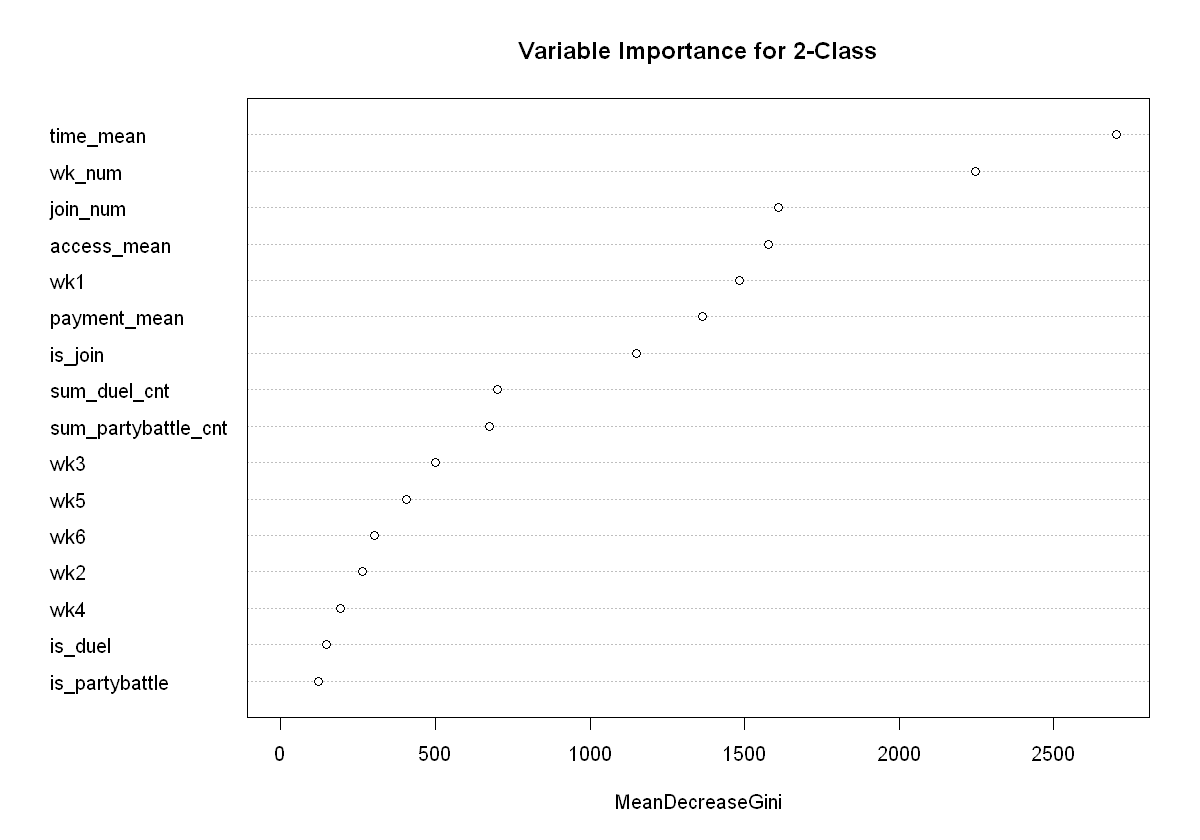

In [28]:
varImp(second_reduced$rf.model)
varImpPlot(second_reduced$rf.model, main = "Variable Importance for 2-Class")

,Overall
payment_mean,1015.2259
join_num,1458.6638
is_join,826.3939
wk1,1431.5184
wk2,498.6443
wk3,555.1803
wk4,649.9127
wk5,650.4967
wk6,480.8322
wk_num,2752.2307


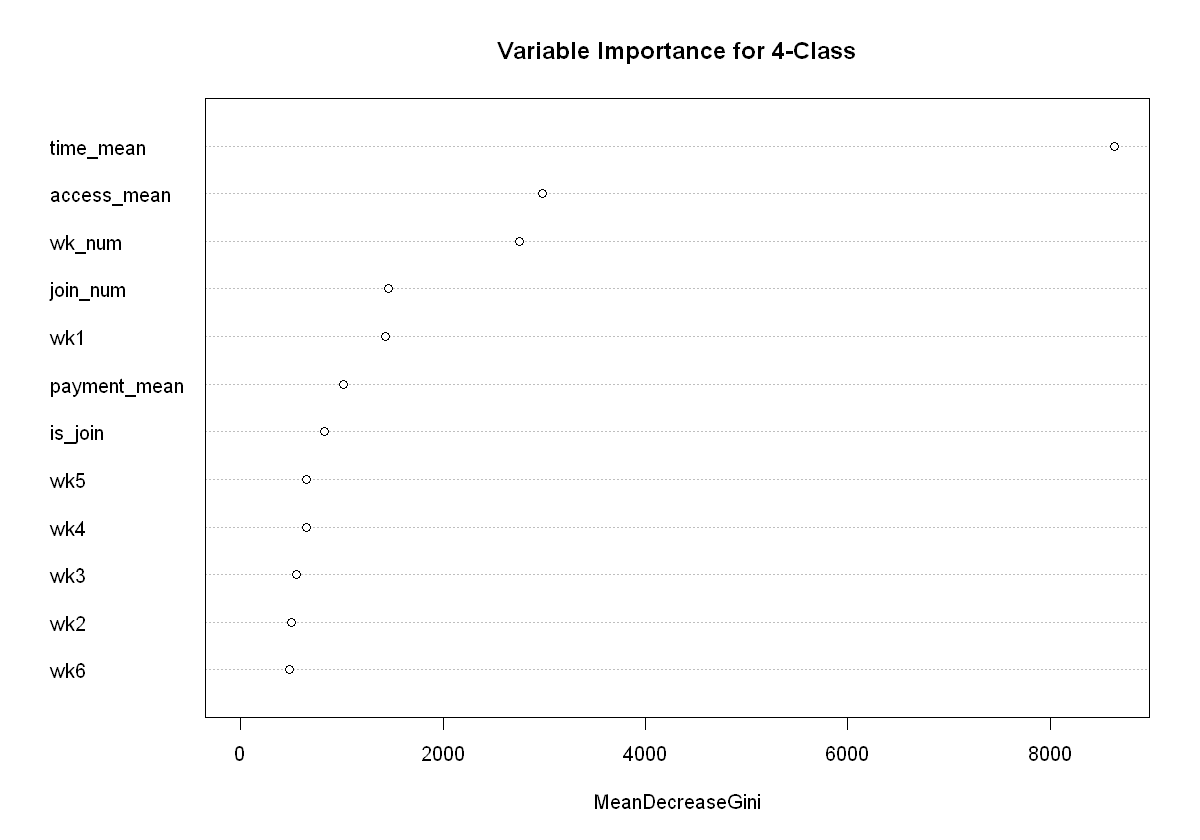

In [29]:
varImp(first$rf.model)
varImpPlot(first$rf.model, main = "Variable Importance for 4-Class")

,Overall
payment_mean,1038.8389
join_num,1507.7432
is_join,915.2115
wk1,1087.5041
wk2,563.8747
wk3,427.2732
wk4,616.5227
wk5,603.5223
wk6,448.6449
wk_num,2196.9482


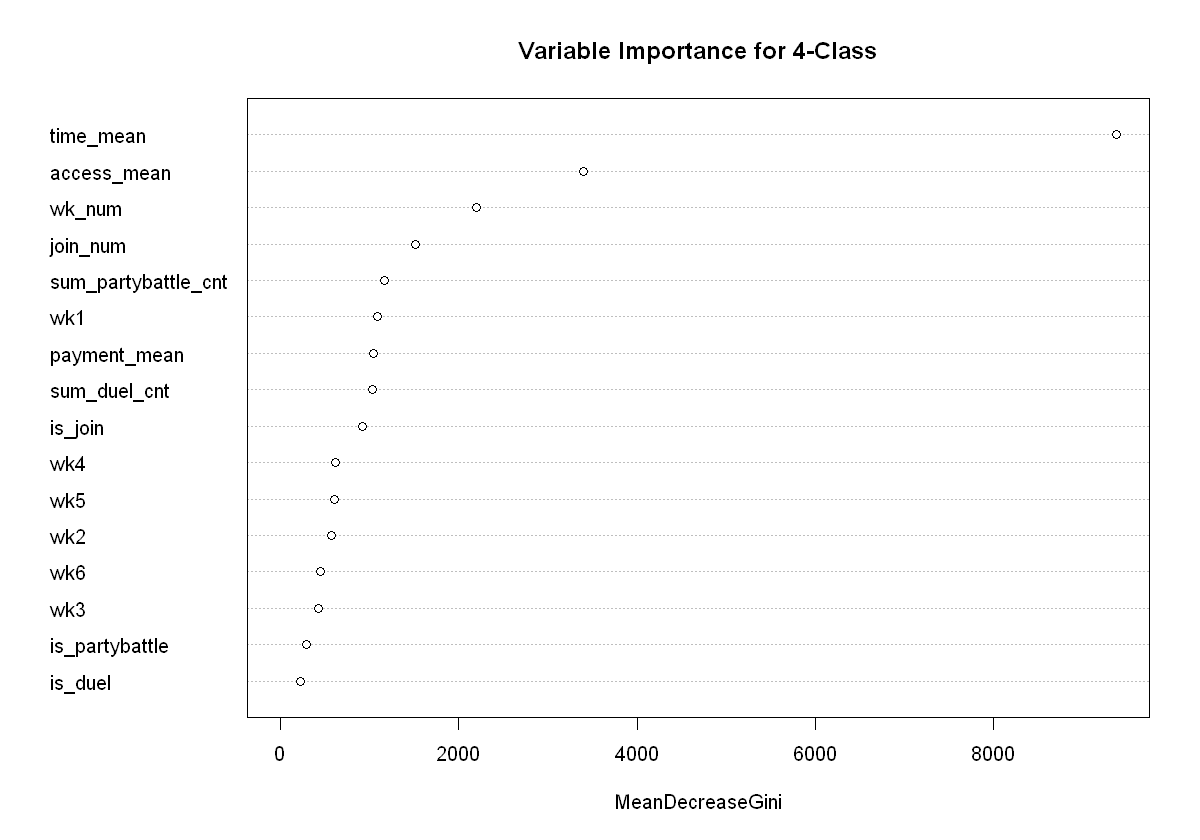

In [30]:
varImp(second$rf.model)
varImpPlot(second$rf.model, main = "Variable Importance for 4-Class")

,Overall
payment_mean,770.37878
join_num,883.73834
is_join,870.90784
wk1,871.82146
wk2,226.66315
wk3,245.26415
wk4,89.43746
wk5,224.46199
wk6,258.77981
wk_num,1182.14912


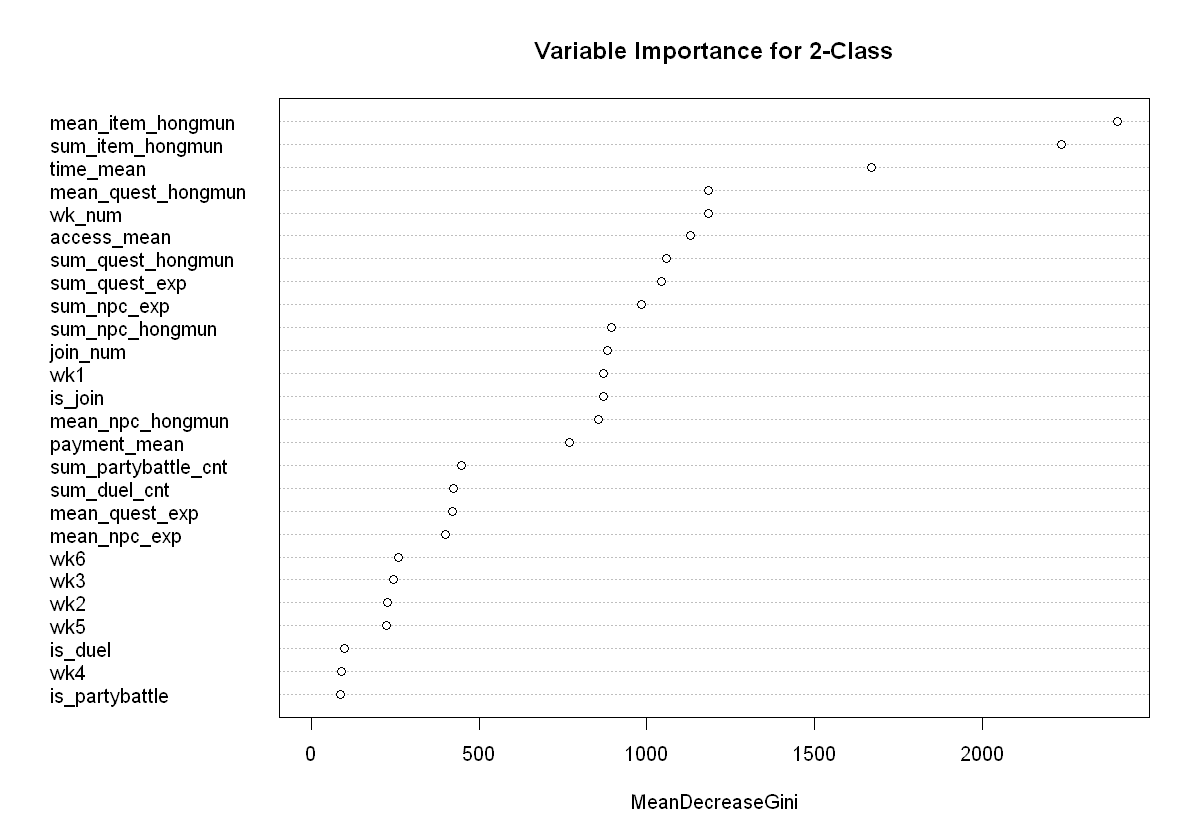

In [31]:
varImp(third_reduced$rf.model)
varImpPlot(third_reduced$rf.model, main = "Variable Importance for 2-Class")

,Overall
payment_mean,507.8040
join_num,784.7960
is_join,432.7273
wk1,883.1084
wk2,191.3365
wk3,233.3913
wk4,247.5083
wk5,214.6942
wk6,319.0152
wk_num,1072.5003


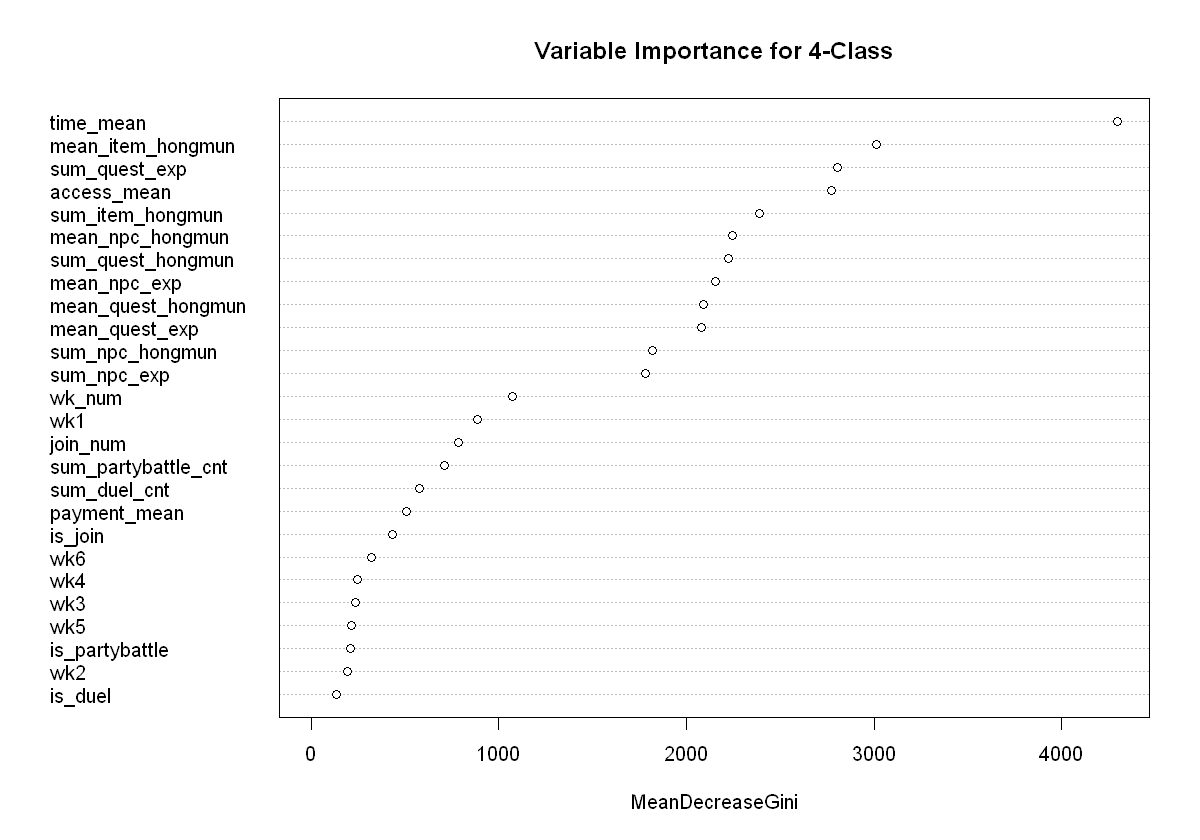

In [32]:
varImp(third$rf.model)
varImpPlot(third$rf.model, main = "Variable Importance for 4-Class")